# The Root-Locus Method

Given the following closed-loop controlled system:   
![](./images/rlocus-system.png)

The root locus method draws the location of the closed-loop poles for all $K \geq 0$.

However, the root-locus method does this by only considering the  open-loop transfer function ( $G(s)H(s)$ ). 

## Preparations

In [7]:
import numpy as np

from sympy import simplify, fraction, solve, expand, Symbol, re, im, Matrix, Eq, diff, latex
from sympy.physics.control.lti import TransferFunction
from sympy.abc import s

from rlocusanim import *

from mathprint import *

## The core function for root-locus plotting

In [8]:
def rlocus(G, H, Kmax=10000, num=100):
    K = Symbol('K', positive=True, real=True)
    
    ol_tf = fraction(simplify(G * H));
    ol_TF = TransferFunction(ol_tf[0], ol_tf[1], s)

    ol_poles = np.complex64(ol_TF.poles())
    ol_zeros = np.complex64(ol_TF.zeros())

    cl_tf = fraction(simplify(K*G / (1+K*G*H)))
    cl_TF = TransferFunction(cl_tf[0], cl_tf[1], s)

    cl_poles = []
    gains = np.logspace(np.log10(0.001), np.log10(Kmax), num)
    gains = np.hstack((0, gains))
    for gain in gains:
        p = cl_TF.subs(K, gain).poles()
        cl_poles.append([p[i].evalf() for i in range(len(p))])

    cl_poles = np.complex64(cl_poles)

    return gains, cl_poles, ol_poles, ol_zeros


## Fiinding the $j\omega$-corssings

The crossings include: $K$ and $\omega$ at when the crossings occur.

In [9]:
def find_jw_crossings(G, H):
    K = Symbol('K', positive=True, real=True)
    omega = Symbol('omega', real=True)

    cl_tf = fraction(simplify(K*G/(1+K*G*H)))
    eq = cl_tf[1].subs(s, omega*1j)

    # Build system equations made by real and immaginary compinents
    eqs = Matrix([re(eq), im(eq)])
    sol = solve(Eq(eqs,Matrix([[0],[0]])), [K,omega])
    sol.insert(0, (K, omega))
    mprint(latex(Matrix(sol)))

## Finding break-away / entry points

Calculated from the characteristic function of the closed-loop-pole transfer function: $\displaystyle 1 + KG(s) H(s) = 0$.  
- Express the closed-loop-pole transfer function as: $K(s)=\dots$ (this should be a polynomial function of $s$-variable).
- At break away / entry point,$\displaystyle \frac{ \mathtt{d} K(s)}{ \mathtt{d} s} = 0$. Solve for $s$. Assume the solutions are $s=\mathcal{S}$.
- To define if the point is valid: $K(\mathcal{S}) > 0$.
- To define whether the point is an entry point or a break-away point:
    - Entry point: $\displaystyle \frac{ \mathtt{d}^2K(\mathcal{S})} { \mathtt{d} s^2} > 0$.
    - Break-away point: $\displaystyle \frac{ \mathtt{d}^2K(\mathcal{S})}{ \mathtt{d} s^2} < 0$.

In [10]:
def find_break_entry_points(G, H):
    K = Symbol('K', positive=True, real=True)

    cl_tf = fraction(simplify(K*G/(1+K*G*H)))
    eq = solve(cl_tf[1], K)[0]
    deq = diff(eq, s)
    ddeq = diff(eq, s, s)
    
    sol = solve(deq, s)
    sols = ([re(sol[i].evalf()) for i in range(len(sol))]) # this results should be only real numbers

    S = []
    for s_ in sols:
        K_ = eq.subs(s, s_)
        if K_ > 0:
            S.append(s_)
    
    STATUS = []
    for s_ in S:
        eq_ = ddeq.subs(s, s_)
        if eq_.evalf() < 0:
            STATUS.append("Break-away point")
        else:
            STATUS.append("Entry point")
    
    return S, STATUS

## Example 1

$$G(s) = \frac{1}{s^3+s^2+45s}$$
$$H(s) = 1$$

### Rot-locus plot

<IPython.core.display.Javascript object>


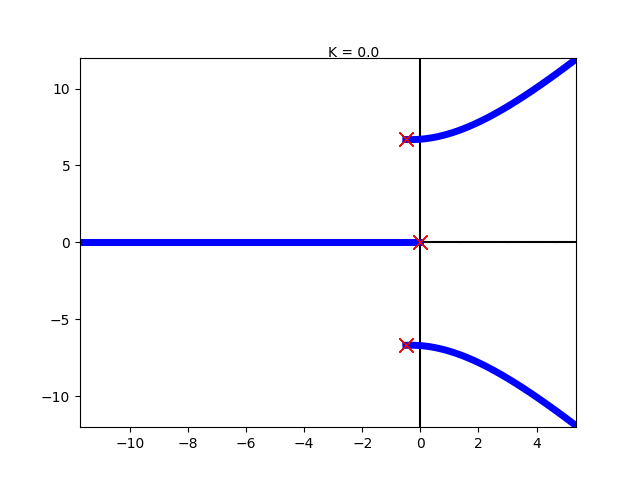

In [11]:
%matplotlib notebook
gains, cl_poles, ol_poles, ol_zeros = rlocus(1/(s**3+s**2+45*s), 1, Kmax=2000);
ani = animate(gains, cl_poles, ol_poles, ol_zeros, gif_fn='./images/1.gif');
display_gif("./images/1.gif");

### $j \omega$-crossings

In [12]:
find_jw_crossings(1/(s**3+s**2+45*s), 1)

<IPython.core.display.Math object>

## Example 2

$$G(s) = \frac{s-1}{s+3}$$
$$H(s) = 1$$

### Root-locus plot

<IPython.core.display.Javascript object>


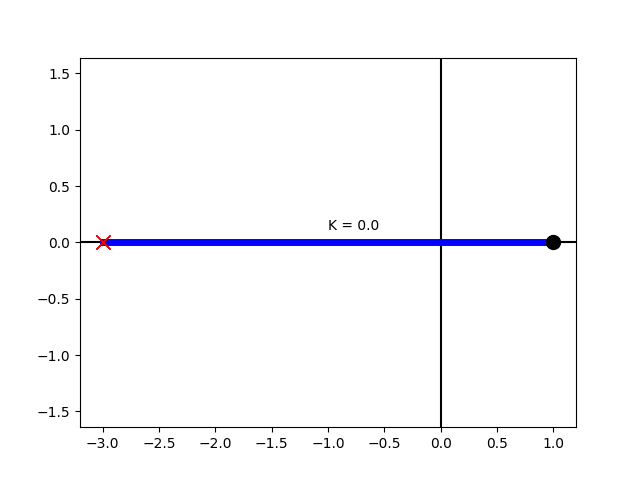

In [13]:
%matplotlib notebook
gains, cl_poles , ol_poles, ol_zeros = rlocus((s-1)/(s+3), 1)
ani = animate(gains, cl_poles, ol_poles, ol_zeros, gif_fn='./images/2.gif');
display_gif("./images/2.gif");

### $j \omega$-crossings

In [14]:
find_jw_crossings((s-1)/(s+3), 1)

<IPython.core.display.Math object>

## Example 3

$$G(s) = \frac{1}{s(1+0.5s)(1+0.1s))}$$
$$H(s) = 1$$

### Root-locus plot

<IPython.core.display.Javascript object>


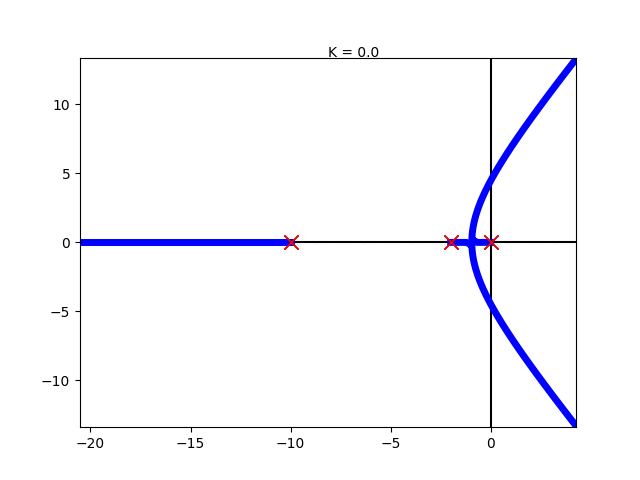

In [15]:
%matplotlib notebook
gains, cl_poles , ol_poles, ol_zeros = rlocus(1/(s*(1+0.5*s)*(1+0.1*s)), 1, Kmax=200)
ani = animate(gains, cl_poles, ol_poles, ol_zeros, gif_fn='./images/3.gif', fps=60);
display_gif("./images/3.gif");

### $j \omega$-crossings

In [16]:
find_jw_crossings(1/(s*(1+0.5*s)*(1+0.1*s)), 1)

<IPython.core.display.Math object>

**For the shake of curiosity, let us do the calculation by hand.**

Substitute $\displaystyle s=j\omega $, and find the $\displaystyle \omega $.
\begin{align*}
1+KG( s) H( s) & =0\\
s(1+0.5s)(1+0.1s)+K & =0\\
0.05s^{3} +0.6s^{2} +s+K & =0\\
0.05( j\omega )^{3} +0.6( j\omega )^{2} +j\omega +K & =0\\
-0.05j\omega ^{3} -0.6\omega ^{2} +j\omega +K & =0\\
\underbrace{-0.6\omega ^{2} +K}_{\text{Re}} +\underbrace{\left( -0.05\omega ^{3} +\omega \right)}_{\text{Im}} j & =\underbrace{0}_{\text{Re}} +\underbrace{0}_{\text{Im}} j
\end{align*}


We can get two equations: $\displaystyle -0.6\omega ^{2} +K=0$ and $\displaystyle -0.05\omega ^{3} +\omega =0.$ 

From: $\displaystyle -0.05\omega ^{3} +\omega =0\Longrightarrow \cancel{\omega =0} \lor \omega =-4.472\lor \omega =4.472$. 

$\displaystyle \omega =0$ does not make any sense.

Take $\displaystyle \omega =\pm 4.472$, substitute $\displaystyle \omega \pm 4.472$ to $\displaystyle -0.6\omega ^{2} +K=0$, and we get $\displaystyle K=12$.

### Break-away / entry points

In [17]:
S, STATUS = find_break_entry_points(1/(s*(1+0.5*s)*(1+0.1*s)), 1)
print(S)
print(STATUS)

[-0.944949536696107]
['Break-away point']


## Example 4

$$G(s) = \frac{(s+2)(s+3)}{s(s+1)}$$
$$H(s) = 1$$

To get a nice root-locus plot, we need to play a bit with the ```Kmax``` and ```num``` arguments. Otherwise, our root-locus plot will look funny.

### Root-locus plot

<IPython.core.display.Javascript object>


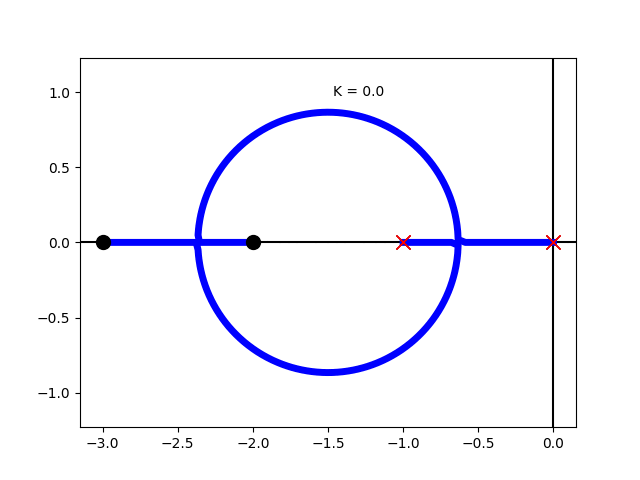

In [18]:
%matplotlib notebook
gains, cl_poles , ol_poles, ol_zeros = rlocus((s+2)*(s+3)/(s*(s+1)), 1, Kmax=100, num=1000)
ani = animate(gains, cl_poles, ol_poles, ol_zeros, gif_fn='./images/4.gif', fps=500);
display_gif("./images/4.gif");

### Break-away / entry points

In [19]:
S, STATUS = find_break_entry_points((s+2)*(s+3)/(s*(s+1)), 1)
print(S)
print(STATUS)

[-2.36602540378444, -0.633974596215561]
['Entry point', 'Break-away point']
